In [31]:
import pandas as pd
import numpy as np
import os
import datetime
import strgen
%config IPCompleter.greedy=True
path = os.getcwd()
os.listdir("C:\\Users\\chris\\OneDrive - Irwin's Safety and Industrial Labour Services Ltd\\Irwins\\output")

['.ipynb_checkpoints',
 '2013_2016.csv',
 'cec_2018.csv',
 'daily.csv',
 'joffre_2018.csv',
 'multiple_areas.csv',
 'SB_analysis.csv',
 'SB_Histograms.xlsx',
 'sheerness_2017.csv',
 'shep_2018.csv',
 'simulation',
 'TA_database.csv',
 'TimeVsCode.xlsx',
 '~$TimeVsCode.xlsx']

In [32]:
import glob
import re
path = "C:\\Users\\chris\\OneDrive - Irwin's Safety and Industrial Labour Services Ltd\\Irwins\\output"
all_files = ['2013_2016.csv', 'cec_2018.csv', 'shep_2018.csv','sheerness_2017.csv', 'joffre_2018.csv']

li = []

for filename in all_files:
    df = pd.read_csv(path+"\\"+filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

In [33]:
data['Shift'] = data['Shift'].replace(['D','N'],['Day','Night'])
data['Shift'].value_counts()

Day      30811
Night     7545
Name: Shift, dtype: int64

In [34]:
# Convert columns to datetime values, and add unique id for Turnarounds
data['clean_date'] = pd.to_datetime(data['clean_date'])
data['start_time'] = pd.to_datetime(data['start_time'])
data['TA_id'] = data['project'] +"_"+ data['year'].astype(str)
data.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38884 entries, 0 to 38883
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   csas_id           38884 non-null  int64         
 1   clean_date        38884 non-null  datetime64[ns]
 2   Code of Practice  38784 non-null  object        
 3   Shift             38356 non-null  object        
 4   Number of Crews   38672 non-null  float64       
 5   duration          26892 non-null  float64       
 6   company           38884 non-null  object        
 7   project           38884 non-null  object        
 8   year              38884 non-null  int64         
 9   WT/DT Cause Code  6226 non-null   object        
 10  time_phase        32972 non-null  object        
 11  code_phase        24093 non-null  object        
 12  person_hours      26788 non-null  float64       
 13  Work Order        18800 non-null  object        
 14  Work Areas        1882

In [35]:
# Add column for working days since start of turnaround
li=[]
for t in data['TA_id'].unique():
    tempdf = data[data['TA_id']==t]
    dates_df = pd.DataFrame(np.sort(tempdf['clean_date'].unique()))
    dates_df['days_from_start']=dates_df.index
    dates_df.columns = ['clean_date','days_from_start']
    mergedf = tempdf.merge(dates_df,left_on='clean_date',right_on='clean_date')
    li.append(mergedf)
data2 = pd.concat(li).reset_index(drop=True)

In [36]:
# Add column for number of CSAs on site
data2['csa_count'] = data2.groupby(['TA_id', 'clean_date'])['csas_id'].transform('nunique')
data2.head()

,csas_id,clean_date,Code of Practice,Shift,Number of Crews,duration,company,project,year,WT/DT Cause Code,...,Work Order,Work Areas,Facility,start_phase,start_time,stop_time,Note,TA_id,days_from_start,csa_count
0,9933003593,2013-06-16,13PH,NaN,2.0,0.166667,Atco Power,Battle River,2013,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Battle River_2013,0,19
1,4956062195,2013-06-16,5RAH,NaN,5.0,0.466667,Atco Power,Battle River,2013,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Battle River_2013,0,19
2,4733289184,2013-06-16,10S,NaN,3.0,1.000000,Atco Power,Battle River,2013,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Battle River_2013,0,19
3,7809457085,2013-06-16,11S,NaN,NaN,2.333333,Atco Power,Battle River,2013,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Battle River_2013,0,19
4,912333567,2013-06-16,PRECIP,NaN,2.0,0.616667,Atco Power,Battle River,2013,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,Battle River_2013,0,19


In [37]:
first_work = pd.DataFrame(data2[(data2['code_phase']=='tool_time')&
                          (data2['duration']>0)].
                          groupby(['csas_id','clean_date'])
                          ['start_time'].min().reset_index())
first_work.columns = ['csas_id', 'clean_date','work_start']
first_work.head()

,csas_id,clean_date,work_start
0,1707681,2014-10-14,NaT
1,2809106,2014-10-19,NaT
2,3972486,2015-02-06,NaT
3,4995742,2017-11-27,2017-11-27 08:28:00
4,5513928,2014-09-30,NaT


In [38]:
first_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5377 entries, 0 to 5376
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   csas_id     5377 non-null   int64         
 1   clean_date  5377 non-null   datetime64[ns]
 2   work_start  776 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 126.1 KB


In [39]:
data3=data2.merge(first_work, left_on = ['csas_id','clean_date'], 
              right_on = ['csas_id','clean_date'], how = 'left')
myconds = [pd.isnull(data3['work_start']) | (data3['start_time']<data3['work_start']), 
           data3['start_time']>=data3['work_start']]
mychoice = ['PreStart','PostStart']
data3['code_timing'] = np.select(myconds, mychoice)
data3['code_timing'].value_counts()

PreStart     22708
0            10696
PostStart     5480
Name: code_timing, dtype: int64

In [40]:
def accountability (row):
    if row['code_phase']== 'tool_time':
        return 'tool time'
    if (row['WT/DT Cause Code']=='SB' or row['WT/DT Cause Code']=='NW' or row['WT/DT Cause Code']=='D'
        or row['WT/DT Cause Code']=='XRAY'  or row['code_phase']=='nonwork_time'):
        return 'shared/unknown'
    if row['code_phase']=='wait_time':
        return 'irwins'
    if row['code_phase']=='down_time':
        return 'facility owner'
    if row['code_phase']=='idle_time':
        return 'workers'

In [41]:
data3['accountability'] = data3.apply(accountability, axis = 1)
data4= data3.dropna(subset=['duration'])
data4['active'] = np.where(data4['code_phase']=='tool_time','working','not working')
data4.sort_values('duration')

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,csas_id,clean_date,Code of Practice,Shift,Number of Crews,duration,company,project,year,WT/DT Cause Code,...,start_time,stop_time,Note,TA_id,days_from_start,csa_count,work_start,code_timing,accountability,active
13577,8696787793,2015-02-01,35210,Day,8.0,0.000000,Atco Power,Sheerness,2015,NaN,...,NaT,NaN,NaN,Sheerness_2015,8,52,NaT,PreStart,None,not working
19312,784654350,2014-02-27,CON-MAC-012,Day,4.0,0.000000,Conifex,Boiler Project,2014,NaN,...,NaT,NaN,NaN,Boiler Project_2014,15,9,NaT,PreStart,None,not working
19311,2187875318,2014-02-27,CON-MAC-006,Day,3.0,0.000000,Conifex,Boiler Project,2014,NaN,...,NaT,NaN,NaN,Boiler Project_2014,15,9,NaT,PreStart,None,not working
19310,8564350621,2014-02-27,CON-MAC-016,Day,3.0,0.000000,Conifex,Boiler Project,2014,NaN,...,NaT,NaN,NaN,Boiler Project_2014,15,9,NaT,PreStart,None,not working
19309,6657628574,2014-02-27,CON-MAC-003,Day,4.0,0.000000,Conifex,Boiler Project,2014,NaN,...,NaT,NaN,NaN,Boiler Project_2014,15,9,NaT,PreStart,None,not working
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,245096011,2013-08-29,31541,Night,17.0,11.233333,Atco Power,Sheerness,2013,NaN,...,NaT,NaN,NaN,Sheerness_2013,5,57,NaT,PreStart,tool time,working
18624,7463110762,2014-10-19,3-7,Day,21.0,11.900000,Capital Power,Genesee G3 Turnaround,2014,NaN,...,NaT,NaN,NaN,Genesee G3 Turnaround_2014,21,52,NaT,PreStart,tool time,working
3420,3396225387,2013-11-04,D-09,Day,5.0,12.000000,Atco Power,Battle River,2013,NaN,...,NaT,NaN,NaN,Battle River_2013,36,28,NaT,PreStart,tool time,working
5777,1323515575,2013-09-02,31541,Night,13.0,12.300000,Atco Power,Sheerness,2013,NaN,...,NaT,NaN,NaN,Sheerness_2013,9,52,NaT,PreStart,tool time,working


In [42]:
workdf = data4.pivot_table(index=['csas_id'],columns='active',
                           values='duration').iloc[:,1].map(lambda x: 'yes' if x>0 else 'no')
workdf.rename('work_occur',inplace=True)
# workdf['work_occur'] = np.where(wordf['working']>0,'yes','no')

csas_id
1707681       yes
2809106       yes
3972486       yes
4995742       yes
5513928       yes
             ... 
9988765836    yes
9990399675    yes
9991773834    yes
9994318580    yes
9998640111    yes
Name: work_occur, Length: 5818, dtype: object

In [43]:
data4 = data4.join(workdf, on = 'csas_id')

In [82]:
daily_entry_per_wo = (data4[['Work Order','clean_date','csas_id']].sort_values
                      (['Work Order','clean_date','csas_id']).drop_duplicates())
daily_entry_per_wo

,Work Order,clean_date,csas_id
25528,44658,2017-11-27,1954179209
25890,44659,2017-11-28,7802447421
24570,444328,2017-11-24,1248098390
24568,444328,2017-11-24,3481378892
24567,444328,2017-11-24,4149450249
...,...,...,...
12121,NaN,2015-02-11,9366345025
12122,NaN,2015-02-11,9789749637
12123,NaN,2015-02-11,9804451851
21156,NaN,2018-04-06,6706973560


In [81]:
daily_entry_per_wo.groupby((daily_entry_per_wo['clean_date'] != daily_entry_per_wo['clean_date']
                                .shift(1)).cumsum()).cumcount()

25528     0
25890     0
24570     0
24568     1
24567     2
         ..
12121    21
12122    22
12123    23
21156     0
21587     0
Length: 5818, dtype: int64

In [72]:
daily_entry_per_wo.groupby((daily_entry_per_wo['clean_date'] != daily_entry_per_wo['clean_date']
                                .shift(1)).cumsum()).cumcount()+1

25528     1
25890     1
24570     1
24568     2
24567     3
         ..
12121    22
12122    23
12123    24
21156     1
21587     1
Length: 5818, dtype: int64

In [46]:
daily_entry_per_wo['unique_entry']=daily_entry_per_wo['Work Order'].astype(str) + " #"+ (daily_entry_per_wo.groupby
                              ((daily_entry_per_wo['clean_date'] != daily_entry_per_wo['clean_date']
                                .shift(1)).cumsum()).cumcount()+1).astype(str)
daily_entry_per_wo.dropna(inplace=True)
daily_entry_per_wo =daily_entry_per_wo[['csas_id','unique_entry']] 

In [47]:
data4 = data4.merge(daily_entry_per_wo,left_on='csas_id', right_on = 'csas_id', 
                    how = 'left')
data4

,csas_id,clean_date,Code of Practice,Shift,Number of Crews,duration,company,project,year,WT/DT Cause Code,...,Note,TA_id,days_from_start,csa_count,work_start,code_timing,accountability,active,work_occur,unique_entry
0,9933003593,2013-06-16,13PH,NaN,2.0,0.166667,Atco Power,Battle River,2013,NaN,...,NaN,Battle River_2013,0,19,NaT,PreStart,shared/unknown,not working,no,NaN
1,4956062195,2013-06-16,5RAH,NaN,5.0,0.466667,Atco Power,Battle River,2013,NaN,...,NaN,Battle River_2013,0,19,NaT,PreStart,shared/unknown,not working,no,NaN
2,4733289184,2013-06-16,10S,NaN,3.0,1.000000,Atco Power,Battle River,2013,NaN,...,NaN,Battle River_2013,0,19,NaT,PreStart,shared/unknown,not working,no,NaN
3,7809457085,2013-06-16,11S,NaN,NaN,2.333333,Atco Power,Battle River,2013,NaN,...,NaN,Battle River_2013,0,19,NaT,PreStart,shared/unknown,not working,no,NaN
4,912333567,2013-06-16,PRECIP,NaN,2.0,0.616667,Atco Power,Battle River,2013,NaN,...,NaN,Battle River_2013,0,19,NaT,PreStart,shared/unknown,not working,no,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26887,7393907317,2018-03-13,73,Day,5.0,0.016667,Atco Power,Joffre,2018,S,...,gas test and waiting on workers,Joffre_2018,10,1,2018-03-13 08:35:00,PostStart,workers,not working,yes,18SO-0008 #1
26888,7393907317,2018-03-13,73,Day,5.0,0.233333,Atco Power,Joffre,2018,NaN,...,NaN,Joffre_2018,10,1,2018-03-13 08:35:00,PostStart,shared/unknown,not working,yes,18SO-0008 #1
26889,7393907317,2018-03-13,73,Day,5.0,1.566667,Atco Power,Joffre,2018,NaN,...,NaN,Joffre_2018,10,1,2018-03-13 08:35:00,PostStart,tool time,working,yes,18SO-0008 #1
26890,7393907317,2018-03-13,73,Day,5.0,0.066667,Atco Power,Joffre,2018,SB,...,no workers present,Joffre_2018,10,1,2018-03-13 08:35:00,PostStart,shared/unknown,not working,yes,18SO-0008 #1


In [48]:
data4.to_csv(path+'\\TA_database.csv',index=False)
data4.TA_id.unique()
vetted_TAs = ['Calgary Energy Centre_2018', 'Shepherd_2018', 'Sheerness_2017',
       'Joffre_2018']

In [49]:
data4.groupby(['TA_id','clean_date','Work Areas','Shift'])['Work Order'].nunique().to_csv(path+'\\multiple_areas.csv',index=True)

In [50]:
data4.columns

Index(['csas_id', 'clean_date', 'Code of Practice', 'Shift', 'Number of Crews',
       'duration', 'company', 'project', 'year', 'WT/DT Cause Code',
       'time_phase', 'code_phase', 'person_hours', 'Work Order', 'Work Areas',
       'Facility', 'start_phase', 'start_time', 'stop_time', 'Note', 'TA_id',
       'days_from_start', 'csa_count', 'work_start', 'code_timing',
       'accountability', 'active', 'work_occur', 'unique_entry'],
      dtype='object')

### When creating a pivot table, remember that any rows that have an na value in the index are not included when aggregating (ie. if Number of Crews is blank, that row is omitted from the following table

In [51]:
daily_by_phase = data4.pivot_table(index=['csas_id','clean_date','TA_id','Number of Crews','days_from_start',
                       'csa_count'],
                columns = 'code_phase',
                values='duration',aggfunc='sum')
daily_by_active = data4.pivot_table(index=['csas_id','clean_date','TA_id','Number of Crews','days_from_start',
                       'csa_count'],
                columns = 'active',
                values='duration',aggfunc='sum')
daily_by_code_timing = data4[data4['active']!='working'].pivot_table(index=['csas_id','clean_date','TA_id','Number of Crews','days_from_start',
                       'csa_count'],
                columns = 'code_timing',
                values='duration',aggfunc='sum')
daily = daily_by_phase.join(daily_by_active)
daily = daily.join(daily_by_code_timing).reset_index()
daily.fillna(0,inplace=True)
# daily['total_time'] = daily['working']+daily['not working']
# daily['tool_time_pct'] = daily['working'] / daily['total_time']
# daily['pre_start_pct'] = daily['PreStart']/(daily['PreStart']+daily['PostStart'])
# daily.fillna(0,inplace=True)
# daily_vetted = daily[daily['TA_id'].isin(vetted_TAs)]
# daily_vetted.to_csv(path+'\\daily.csv',index=False)

In [52]:
daily_by_code_timing

,,,,,code_timing,PostStart,PreStart
csas_id,clean_date,TA_id,Number of Crews,days_from_start,csa_count,,
1707681,2014-10-14,Genesee G3 Turnaround_2014,2.0,16,58,NaN,7.233333
2809106,2014-10-19,Calgary Energy Centre_2014,5.0,3,9,NaN,2.050000
3972486,2015-02-06,Sheerness_2015,3.0,13,55,NaN,0.450000
4995742,2017-11-27,Sheerness_2017,1.0,12,38,7.666667,0.716667
5513928,2014-09-30,Genesee G3 Turnaround_2014,1.0,2,40,NaN,1.833333
...,...,...,...,...,...,...,...
9988765836,2014-10-10,Genesee G3 Turnaround_2014,6.0,12,62,NaN,0.583333
9990399675,2013-09-21,Sheerness_2013,2.0,28,47,NaN,0.633333
9991773834,2014-03-18,Boiler Project_2014,5.0,28,4,NaN,0.783333


In [53]:
data_sb = data.dropna(subset=['duration'])[(data['code_phase']!='tool_time')&(data['WT/DT Cause Code']=='SB')].copy()
data_sb.columns

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Index(['csas_id', 'clean_date', 'Code of Practice', 'Shift', 'Number of Crews',
       'duration', 'company', 'project', 'year', 'WT/DT Cause Code',
       'time_phase', 'code_phase', 'person_hours', 'Work Order', 'Work Areas',
       'Facility', 'start_phase', 'start_time', 'stop_time', 'Note', 'TA_id'],
      dtype='object')

In [54]:
data_sb['TA_id'].value_counts()

Genesee G3 Turnaround_2014    724
Sheerness_2017                674
Sheerness_2015                618
Calgary Energy Centre_2018    127
Joffre_2018                    81
Shepherd_2018                  71
Calgary Energy Centre_2014     35
Name: TA_id, dtype: int64

In [55]:
first_work = pd.DataFrame(data[data['code_phase']=='tool_time'].
                          groupby(['Work Order','Work Areas','clean_date','Shift'])
                          ['start_time'].min().reset_index())
first_work.columns = ['Work Order', 'Work Areas', 'clean_date', 'Shift','work_start']
first_work.head()

,Work Order,Work Areas,clean_date,Shift,work_start
0,44658,Furnace Throat Waterwall Upgrades Breaker Bar,2017-11-27,Day,2017-11-27 08:02:00
1,44659,Secondary Superheater/Reheater Inspection and ...,2017-11-28,Day,2017-11-28 08:03:00
2,444328,Precipitators P1,2017-11-24,Day,2017-11-24 08:24:00
3,444335,Primary Air Heaters,2017-11-24,Day,2017-11-24 08:20:00
4,444335,Primary Air Heaters,2017-11-25,Day,2017-11-25 08:12:00


In [56]:
data_sb2=data_sb.merge(first_work, left_on = ['Work Order','Work Areas','clean_date','Shift'], 
              right_on = ['Work Order','Work Areas','clean_date','Shift'], how = 'left')
myconds = [pd.isnull(data_sb2['start_time']), data_sb2['start_time']<data_sb2['work_start'], data_sb2['start_time']>data_sb2['work_start']]
mychoice = ["", 'PreStart','PostStart']
data_sb2['timing'] = np.select(myconds, mychoice)
data_sb2.to_csv(path+'\\SB_analysis.csv',index=False)

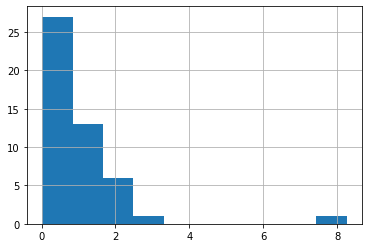

In [57]:
data_sb2[((data_sb2['TA_id']=='Calgary Energy Centre_2018') | (data_sb2['TA_id']=='Shepherd 2018'))& (data_sb2['timing']=='PreStart')]['duration'].hist()